In this notebook, we compute invariant sets for the planar system with univariate input of [Example 2 of [AT19]](https://github.com/janis10/cis2m/blob/master/example3D.m).
We need to select an semidefinite programming solver to find the invariant set. A complete list of available solvers is [available here](https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1).

[AT19] Tzanis Anevlavis and Paulo Tabuada, "Computing controlled invariant sets in two moves", In 2019 IEEE Conference on Decision and Control (CDC).

In [1]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET => 1))

We first define the safe sets and input sets for our system using [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
G = [-0.9497  0.3212 -0.8258
     -0.1578 -0.2323  0.6042
     -0.6318  0.2547  0.9783
      0.4516 -0.9567 -0.8661
     -0.2593  0.8211  0.8788
      0.6831  0.6011 -0.9636
      0.4685  0.4917  0.3677
      0.1421  0.6262  0.5675
     -0.6463 -0.2334  0.0683
      0.9148  0.2346  0.7707
     -0.4694  0.1510  0.7980
      0.8492  0.0601  0.2519
     -0.5525 -0.4499 -0.7243
     -0.2529 -0.5027 -0.5644
     -0.8250 -0.0967 -0.6357
      0.2802 -0.5446 -0.9164
     -0.6388  0.6089 -0.7861
     -0.9099  0.9722  0.2329
      0.4463 -0.9400  0.8793
     -0.3051  0.0713 -0.2911]
F = [0.4106
     0.9843
     0.9456
     0.6766
     0.9883
     0.7668
     0.3367
     0.6624
     0.2442
     0.2955
     0.6802
     0.5278
     0.4116
     0.6026
     0.7505
     0.5835
     0.5518
     0.5836
     0.5118
     0.0826]
safe_set = polyhedron(hrep(G, F), DefaultLibrary{Float64}(solver))
using SemialgebraicSets
input_set = FullSpace()

Algebraic Set defined by no equality


We new define the dynamic of our system and create it using [MathematicalSystems](https://github.com/JuliaReach/MathematicalSystems.jl/).

In [3]:
using MathematicalSystems
A = [ 0  1 -2
      3 -4  5
     -6  7  8]
B = reshape([-1; 2; 4], 3, 1)
system = ConstrainedLinearControlDiscreteSystem(A, B, safe_set, input_set)

ConstrainedLinearControlDiscreteSystem{Int64,Array{Int64,2},Array{Int64,2},DefaultPolyhedron{Float64,MixedMatHRep{Float64,Array{Float64,2}},MixedMatVRep{Float64,Array{Float64,2}}},FullSpace}([0 1 -2; 3 -4 5; -6 7 8], [-1; 2; 4], HalfSpace([-0.9497, 0.3212, -0.8258], 0.4106) ∩ HalfSpace([-0.1578, -0.2323, 0.6042], 0.9843) ∩ HalfSpace([-0.6318, 0.2547, 0.9783], 0.9456) ∩ HalfSpace([0.4516, -0.9567, -0.8661], 0.6766) ∩ HalfSpace([-0.2593, 0.8211, 0.8788], 0.9883) ∩ HalfSpace([0.6831, 0.6011, -0.9636], 0.7668) ∩ HalfSpace([0.4685, 0.4917, 0.3677], 0.3367) ∩ HalfSpace([0.1421, 0.6262, 0.5675], 0.6624) ∩ HalfSpace([-0.6463, -0.2334, 0.0683], 0.2442) ∩ HalfSpace([0.9148, 0.2346, 0.7707], 0.2955) ∩ HalfSpace([-0.4694, 0.151, 0.798], 0.6802) ∩ HalfSpace([0.8492, 0.0601, 0.2519], 0.5278) ∩ HalfSpace([-0.5525, -0.4499, -0.7243], 0.4116) ∩ HalfSpace([-0.2529, -0.5027, -0.5644], 0.6026) ∩ HalfSpace([-0.825, -0.0967, -0.6357], 0.7505) ∩ HalfSpace([0.2802, -0.5446, -0.9164], 0.5835) ∩ HalfSpace([-0.6

We now use SwitchOnSafety to compute the invariant set. We start with symmetric ellipsoid centered at the origin.

In [4]:
using SwitchOnSafety
sym_variable = Ellipsoid(symmetric = true)
max_vol_sym_ell = invariant_set(system, solver, sym_variable)

MOI.get(model, MOI.SolveTime()) = 0.005156040191650391
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.013724450099832168


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.08092673510779361 0.05131655994585307 -0.0741319233487163; 0.05131655994585307 0.033545713087152935 -0.039764992072115396; -0.0741319233487163 -0.039764992072115396 0.15186636023294206]))

This computes the maximal *volume* ellipsoid.
We can instead maximize the integral of the quadratic form defining the ellipsoid over the hypercube.
This corresponds to maximizing the sum of squares of its semi-axes instead or equivalently the trace of the positive definite matrix defining the quadratic form.

In [5]:
max_tr_sym_ell = invariant_set(system, solver, sym_variable, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0017189979553222656
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.24438019907463568


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.07477722921439671 0.038647760032602084 -0.13772776667986142; 0.038647760032602084 0.020131136916234055 -0.069505233605906; -0.13772776667986142 -0.069505233605906 0.27166193248132275]))

We can see the result below.

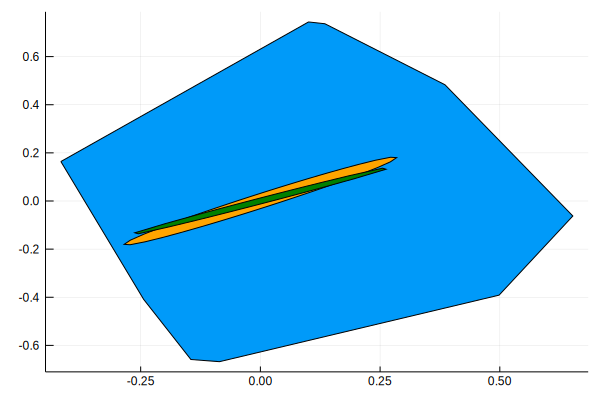

In [6]:
using Plots
I = [1, 2]
plot(project(safe_set, I))
plot!(project(max_vol_sym_ell, I), color=:orange, npoints=256)
plot!(project(max_tr_sym_ell, I), color=:green, npoints=256)

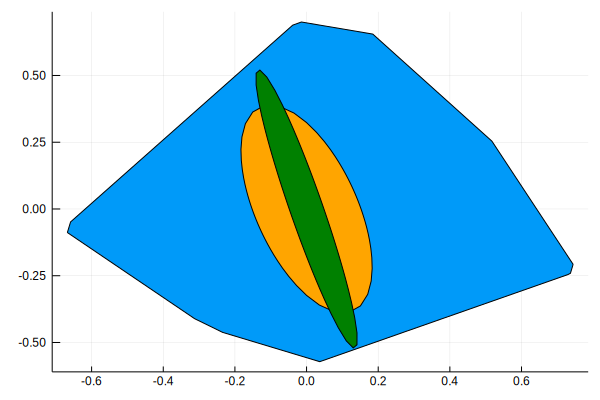

In [7]:
using Plots
I = [2, 3]
plot(project(safe_set, I))
plot!(project(max_vol_sym_ell, I), color=:orange)
plot!(project(max_tr_sym_ell, I), color=:green, npoints=256)

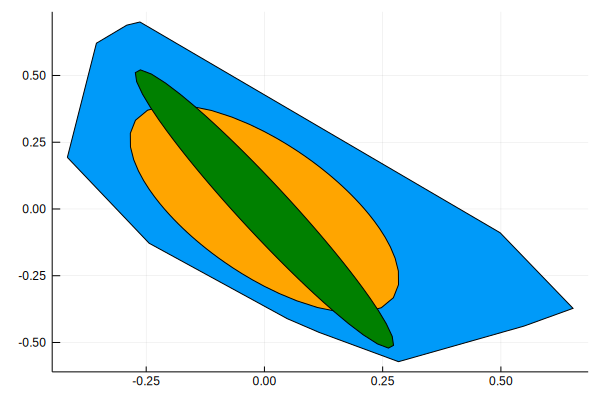

In [8]:
using Plots
I = [1, 3]
plot(project(safe_set, I))
plot!(project(max_vol_sym_ell, I), color=:orange)
plot!(project(max_tr_sym_ell, I), color=:green, npoints=256)

We can see that forcing the center of the ellipsoid to coincide with the origin is quite conservative.
We can ask instead to search for any ellipsoid with the chebyshev of the safe set in its interior.
To avoid having to solve Bilinear Matrix Inequalities, we set the S-procedure scaling with `λ`.

In [9]:
using SwitchOnSafety
variable = Ellipsoid(point = SetProg.InteriorPoint(zeros(3)))
max_vol_ell = invariant_set(system, solver, variable, λ = 1.01)

MOI.get(model, MOI.SolveTime()) = 0.00549006462097168
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.015754833733250324


SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}}(SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}(SetProg.Sets.ShiftedEllipsoid{Float64}([0.0982519925600691 0.061168306453809225 -0.10124217674645965; 0.061168306453809225 0.03915687865283022 -0.05526975521577351; -0.10124217674645965 -0.05526975521577351 0.1973144051260105], [0.037732494370702356, 0.02753132979531179, -0.010047261439687068], -0.9703289058814827), -0.9703289058814827z² - 0.07546498874140471zx₁ - 0.05506265959062358zx₂ + 0.020094522879374136zx₃ + 0.0982519925600691x₁² + 0.12233661290761845x₁x₂ - 0.2024843534929193x₁x₃ + 0.03915687865283022x₂² - 0.11053951043154701x₂x₃ + 0.1973144051260105x₃², [0.0, 0.0, 0.0], z, DynamicPolynomials.PolyVar{true}[x₁, x₂, x₃]))

Instead of maximizing the volume, we can maximize the L1 norm as above.

In [10]:
using SwitchOnSafety
max_tr_ell = invariant_set(system, solver, variable, λ = 1.12, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0033559799194335938
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.2540007252948867


SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}}(SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}(SetProg.Sets.ShiftedEllipsoid{Float64}([0.07897184863546788 0.041907554673498514 -0.1275589354512373; 0.041907554673498514 0.023330513614764972 -0.05878482339129279; -0.1275589354512373 -0.05878482339129279 0.2786987256920972], [0.0171506179353049, 0.017746382272004195, 0.04282780241780359], -0.9278121036320184), -0.9278121036320184z² - 0.0343012358706098zx₁ - 0.03549276454400839zx₂ - 0.08565560483560718zx₃ + 0.07897184863546788x₁² + 0.08381510934699703x₁x₂ - 0.2551178709024746x₁x₃ + 0.023330513614764972x₂² - 0.11756964678258558x₂x₃ + 0.2786987256920972x₃², [0.0, 0.0, 0.0], z, DynamicPolynomials.PolyVar{true}[x₁, x₂, x₃]))

We can see that we get a larger ellipsoids for the volume maximization but not for the L1 norm as maximizing the L1 integral over the hypercube centered at the origin is not a very good heuristic. We should instaed maximize the L1 integral over the safe set but this is not implemented yet in [SetProg](https://github.com/blegat/SetProg.jl).

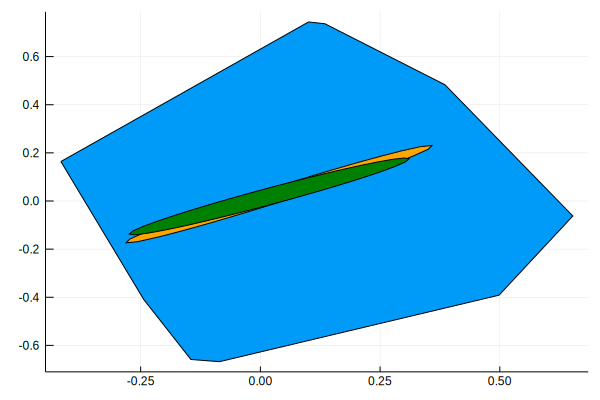

In [11]:
using Plots
I = [1, 2]
plot(project(safe_set, I))
plot!(project(max_vol_ell, I), color=:orange, npoints=256)
plot!(project(max_tr_ell, I), color=:green, npoints=256)

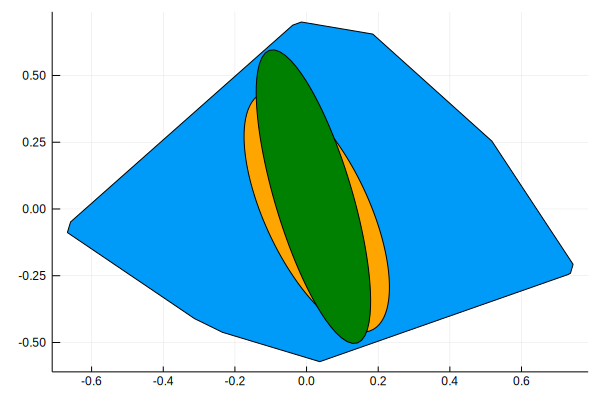

In [12]:
using Plots
I = [2, 3]
plot(project(safe_set, I))
plot!(project(max_vol_ell, I), color=:orange, npoints=256)
plot!(project(max_tr_ell, I), color=:green, npoints=256)

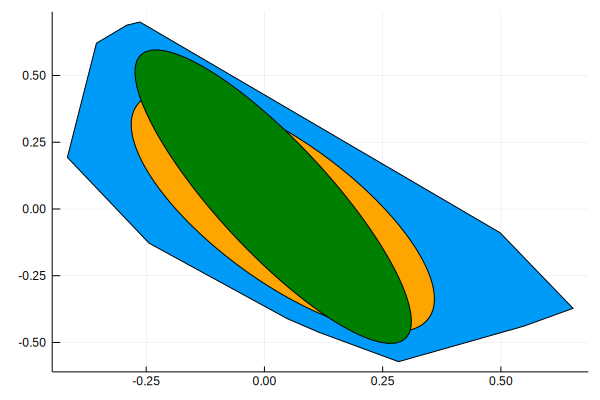

In [13]:
using Plots
I = [1, 3]
plot(project(safe_set, I))
plot!(project(max_vol_ell, I), color=:orange, npoints=256)
plot!(project(max_tr_ell, I), color=:green, npoints=256)